In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import random
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random
import contextlib
from scipy.stats import skew, kurtosis
from scipy.spatial import distance
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import acf, pacf
from collections import Counter
import matplotlib.pyplot as plt
from torchviz import make_dot

import gymnasium
from gymnasium import spaces
from copy import deepcopy
from typing import Any, ClassVar, Dict, List, Optional, Type, TypeVar, Union
import os

from stable_baselines3.common.distributions import CategoricalDistribution
from stable_baselines3.common.utils import constant_fn
from stable_baselines3.common.buffers import RolloutBuffer
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.on_policy_algorithm import OnPolicyAlgorithm
from stable_baselines3.common.policies import BasePolicy
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.utils import explained_variance, get_schedule_fn, obs_as_tensor
from stable_baselines3.common.vec_env import VecEnv
from stable_baselines3.common.callbacks import CheckpointCallback
from sb3_contrib import RecurrentPPO
from sb3_contrib.common.recurrent.buffers import RecurrentDictRolloutBuffer, RecurrentRolloutBuffer
from sb3_contrib.common.recurrent.policies import RecurrentActorCriticPolicy
from sb3_contrib.common.recurrent.type_aliases import RNNStates
from stable_baselines3.common.policies import ActorCriticPolicy
from sb3_contrib.ppo_recurrent.policies import CnnLstmPolicy, MlpLstmPolicy, MultiInputLstmPolicy

In [149]:
# Define the AR(5) coefficients: e.g., X_t = 0.5*X_{t-1} - 0.4*X_{t-2} + 0.3*X_{t-3} - 0.2*X_{t-4} + 0.1*X_{t-5} + epsilon_t
ar_params = np.array([1, -0.6, 0.4, -0.3, 0.2, -0.1])  # AR(5)
ma_params = np.array([1, 0.5, -0.3])  # MA(2)

# Create the ARMA process (with MA part being just [1])
ar_process = ArmaProcess(ar_params, ma_params)

# Simulate 100,000 points of the AR(10) process
n_points = 100000
Price_AR = ar_process.generate_sample(nsample=n_points)

# Price Deltas
Delta_AR = np.diff(Price_AR)

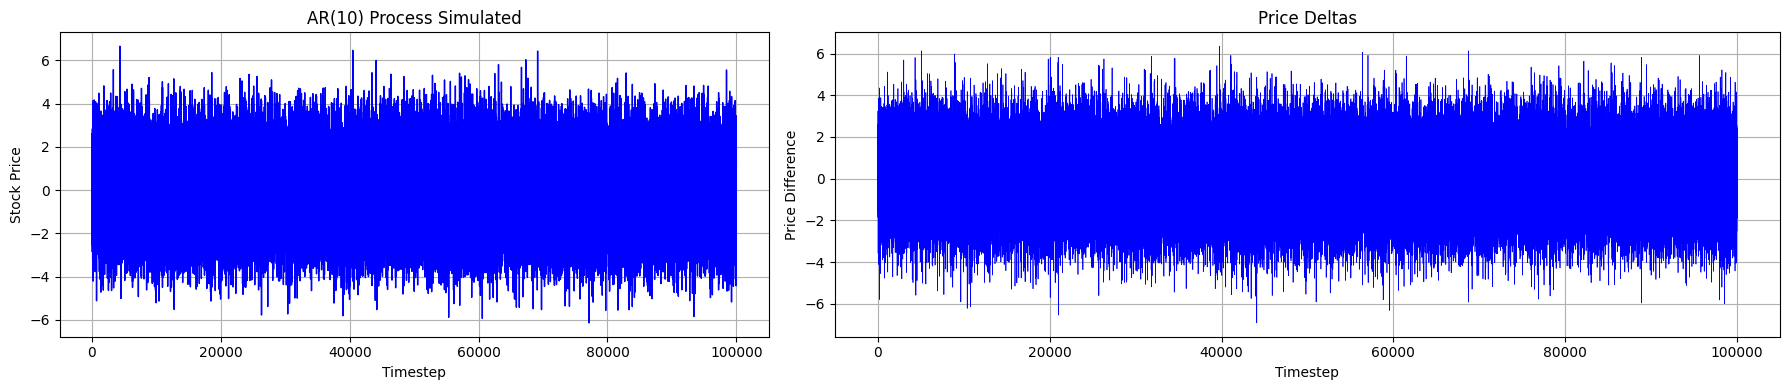

In [150]:
fig, axs = plt.subplots(1, 2, figsize=(18, 4), gridspec_kw={'width_ratios': [1.5, 2]})
axs[0].plot(Price_AR, color='blue', linewidth=1)
axs[0].set_title('AR(10) Process Simulated')
axs[0].set_xlabel('Timestep')
axs[0].set_ylabel('Stock Price')
axs[0].grid('True')

axs[1].plot(Delta_AR, color='blue', linewidth=0.5)
axs[1].set_title('Price Deltas')
axs[1].set_xlabel('Timestep')
axs[1].set_ylabel('Price Difference')
axs[1].grid('True')
plt.tight_layout()
plt.show()

In [151]:
# Find the roots of the characteristic polynomial
roots = np.roots(ar_params)

# Check if the absolute value of all roots is greater than 1
stationary = np.all(np.abs(roots) > 1)

print("Roots of the characteristic equation:", roots)
print("Is the process stationary?", stationary)


Roots of the characteristic equation: [-0.32367174+0.59167523j -0.32367174-0.59167523j  0.60393419+0.j
  0.32170464+0.51043702j  0.32170464-0.51043702j]
Is the process stationary? False


In [152]:
bin_width = 0.1
hidden_dim = 128

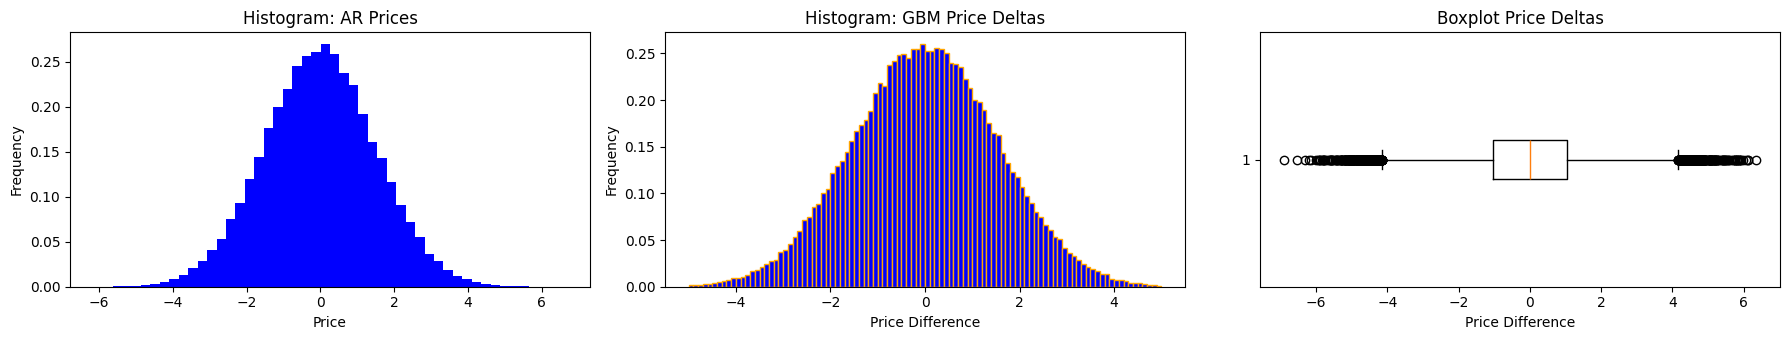

In [153]:
fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

# Histogram: AR Prices
axs[0].hist(Price_AR, bins=50, color='blue', density=True)
axs[0].set_title('Histogram: AR Prices')
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Frequency')

bins = np.arange(-5, 5 + bin_width, bin_width)

# Histogram: AR Price Deltas
axs[1].hist(Delta_AR, 
            bins=bins,
            edgecolor='orange', color='blue', density=True)
axs[1].set_title('Histogram: GBM Price Deltas')
axs[1].set_xlabel('Price Difference')
axs[1].set_ylabel('Frequency')

# Boxplot Price Deltas
axs[2].boxplot(Delta_AR, vert=False)
axs[2].set_title('Boxplot Price Deltas')
axs[2].set_xlabel('Price Difference')
plt.tight_layout()
plt.show()


Standard deviation of price deltas

In [154]:
np.std(Delta_AR)

1.5458364564511615

In [155]:
data = np.array(Delta_AR)

# Bin range and Bin width
bin_start = -5.0
bin_stop = 5.0

num_bins = int((bin_stop - bin_start) / bin_width)  # Calculate number of bins
bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)

# Tokenize the data
tokenized_data = np.digitize(data, bins=bin_edges, right=False) - 1

# Clip any deltas below -0.7 to the first bin and above 0.7 to the last bin
tokenized_data = np.clip(tokenized_data, 0, num_bins - 1)

# Train / Test Split
train_data_temp, temp_data = train_test_split(tokenized_data, train_size=0.6, shuffle=False)
val_data_temp, test_data_temp = train_test_split(temp_data, test_size=0.5, shuffle=False)

def prep_data(seq_len, start_indexes, data):
    final_list = []
    for i in start_indexes:
        final_list.append(data[i:i+seq_len])
    return final_list

print('Number of Tokens:', num_bins)

Number of Tokens: 100


LSTM Model

In [156]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM Layer with 2 layers
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)  # Set num_layers=2
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, hidden):
        # Embedding Layer
        embedded = self.embedding(x)                            # Shape: [batch_size, sequence_length, embedding_dim]
        # LSTM Layer (with 2 stacked layers)
        lstm_out, (h_n, c_n) = self.lstm(embedded, hidden)      # Shape: [batch_size, sequence_length, hidden_dim]
        # Apply Fully Connected Layer to each time step
        logits = self.fc(lstm_out)                              # Shape: [batch_size, sequence_length, output_dim]

        return logits, (h_n, c_n)                               # Return predictions for each time step

#### Train setting:

| Train set:                           |     $\approx$ 60'000         |
| ------------------------------------ | ---------------------------- |
| **Sequence Length:**                 | **50**                       |
| Sequences for a full epoch:          | $\approx$ 1200               |
| **Batch size:**                      | **512**                      |
| Episode length:                      | 1 Batch or 512 sequences     |


In [157]:
seq_len = 50                                                    # Sequence Length
batch_size = 512                                                # Batch Size
learning_rate = 0.001                                           # Learning Rate Adam Optimizer
num_episodes = int(len(train_data_temp)/(seq_len*batch_size))   # Number of episodes for one Epoch

num_epochs = 500

In [158]:
num_bins

100

VALIDATION & TEST DATA

In [159]:
#n_val_seq = len(val_data_temp) // seq_len
#val_data = [val_data_temp[i*seq_len:(i+1)*seq_len] for i in range(32)]
n_val_seq = len(val_data_temp) // seq_len
val_data = [val_data_temp[i*seq_len:(i+1)*seq_len] for i in range(n_val_seq)]

n_test_seq = len(test_data_temp) // seq_len
test_data = [test_data_temp[i*seq_len:(i+1)*seq_len] for i in range(n_test_seq)]

TRAINING

In [160]:
ss_model = LSTMModel(vocab_size=num_bins, embedding_dim=32, hidden_dim=hidden_dim, output_dim=num_bins)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ss_model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

best_val_loss = float('inf')

for epoch in range(num_epochs):

    avg_train_loss = 0
    avg_val_loss = 0

    for episode in range(num_episodes):

        ## ============
        ## TRAINING
        ## ============

        ss_model.train()
        ss_model.zero_grad()

        # Sample the Batch 
        start_train_idx = np.random.choice(range(len(train_data_temp) - seq_len), size=batch_size, replace=True)
        train_data = prep_data(seq_len=seq_len, start_indexes=start_train_idx, data=train_data_temp)

        # Create Tensor of Sequence and Target

        sequence_inputs = torch.tensor(np.array([seq[:-1] for seq in train_data]))    # Remove Last Token
        targets = torch.tensor(np.array([seq[1:] for seq in train_data]))             # Remove First Token

        # Forward pass: Shape [batch_size, sequence_length - 1, output_dim]
        logits, _ = ss_model(sequence_inputs, None)

        # [batch_size*sequence_length-1, output_dim/unique Tokens]
        logits = logits.view(-1, logits.size(-1))
        # Flatten targets: [batch_size*sequence_length-1]
        targets = targets.view(-1)

        loss = criterion(logits, targets)          # Loss
        ss_model.zero_grad()
        loss.backward()                            # Backward pass
        optimizer.step()                           # Update weights
        avg_train_loss += loss.item()              # Save Loss

        ## ============
        ## VALIDATION
        ## ============
        
        ss_model.eval()
        
        sequence_inputs = torch.tensor([seq[:-1] for seq in val_data])  # Remove Last Token
        targets = torch.tensor([seq[1:] for seq in val_data])
        
        with torch.no_grad():
            logits, _ = ss_model(sequence_inputs, None) # Forward Pass
            logits = logits.view(-1, logits.size(-1))   # Flatten Logits
            targets = targets.view(-1)                  # Flatten targets
            loss = criterion(logits, targets)           # Loss
            avg_val_loss += loss.item()                 # Save Loss

    epoch_train_loss = avg_train_loss/num_episodes      # Avg Train Loss after Epoch
    epoch_val_loss = avg_val_loss/num_episodes          # Avg Val Loss after Epoch
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)

    if epoch_val_loss < best_val_loss:
        best_val_loss = best_val_loss
        torch.save(ss_model.state_dict(), 'ar_ss_weights.pth')

    # Optional: Save model every 50 epochs, regardless of validation loss
    if epoch % 50 == 0:
        torch.save(ss_model.state_dict(), f'ar_ss_weights_epoch_{epoch}.pth')
    
    print(f"Epoch {epoch} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")


Epoch 0 - Train Loss: 4.6034 - Val Loss: 4.5968
Epoch 1 - Train Loss: 4.5883 - Val Loss: 4.5796
Epoch 2 - Train Loss: 4.5676 - Val Loss: 4.5541
Epoch 3 - Train Loss: 4.5356 - Val Loss: 4.5078
Epoch 4 - Train Loss: 4.4705 - Val Loss: 4.4158
Epoch 5 - Train Loss: 4.3556 - Val Loss: 4.3012
Epoch 6 - Train Loss: 4.2740 - Val Loss: 4.2564
Epoch 7 - Train Loss: 4.2574 - Val Loss: 4.2386
Epoch 8 - Train Loss: 4.2430 - Val Loss: 4.2160
Epoch 9 - Train Loss: 4.2144 - Val Loss: 4.1964
Epoch 10 - Train Loss: 4.2023 - Val Loss: 4.1844
Epoch 11 - Train Loss: 4.1931 - Val Loss: 4.1783
Epoch 12 - Train Loss: 4.1838 - Val Loss: 4.1755
Epoch 13 - Train Loss: 4.1803 - Val Loss: 4.1736
Epoch 14 - Train Loss: 4.1864 - Val Loss: 4.1718
Epoch 15 - Train Loss: 4.1877 - Val Loss: 4.1694
Epoch 16 - Train Loss: 4.1806 - Val Loss: 4.1667
Epoch 17 - Train Loss: 4.1713 - Val Loss: 4.1637
Epoch 18 - Train Loss: 4.1681 - Val Loss: 4.1615
Epoch 19 - Train Loss: 4.1681 - Val Loss: 4.1603
Epoch 20 - Train Loss: 4.1743 

KeyboardInterrupt: 

Loss and Entropy

In [161]:
def calculate_entropy(sequence):
    token_counts = Counter(sequence)
    total_tokens = len(sequence)
    # Probability distribution of tokens
    probabilities = {token: count / total_tokens for token, count in token_counts.items()}
    # Calculate the Shannon entropy
    entropy = -sum(p * np.log(p) for p in probabilities.values())
    return entropy

In [162]:
print('Entropy of Validation Data:', round(calculate_entropy(val_data_temp), 4))

Entropy of Validation Data: 4.1437


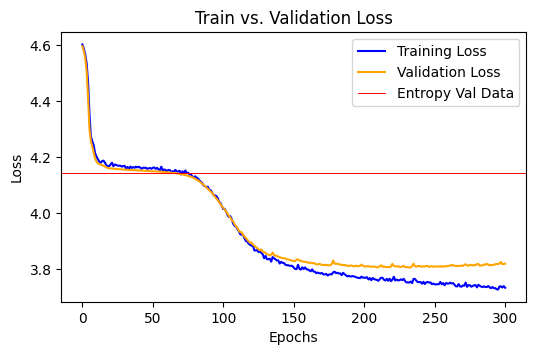

In [163]:
plt.figure(figsize=(6, 3.5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label = 'Validation Loss', color='orange')
plt.axhline(calculate_entropy(val_data_temp), color='red', linewidth=0.7, label='Entropy Val Data')
plt.title('Train vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [165]:
evaluation_model = LSTMModel(vocab_size=num_bins, embedding_dim=32, hidden_dim=hidden_dim, output_dim=num_bins)
evaluation_model.load_state_dict(torch.load('ar_ss_weights.pth', weights_only=False))

val_loss = []
val_perplexity = []

test_loss = []
test_perplexity = []

evaluation_model.eval()
with torch.no_grad():
    
    # Validation Data
    for sequence in val_data:
        
        sequence_input = torch.tensor(sequence[:-1]).unsqueeze(0)   # Exclude last token
        targets = torch.tensor(sequence[1:]).unsqueeze(0)           # Exclude first token
        logits, _ = evaluation_model(sequence_input, None)          # Forward pass
        logits = logits.view(-1, logits.size(-1))                   # Shape: [49, 27]
        targets = targets.view(-1)                                  # Shape: [49]
        
        # Cross entropy Loss
        loss = criterion(logits, targets)
        val_loss.append(loss.item())

        # Log probabilities
        log_probs = F.log_softmax(logits, dim=-1)
        target_log_probs = log_probs[range(len(targets)), targets]

        # Perplexity: exp(-average log probability)
        avg_log_prob = target_log_probs.mean()
        perplexity = torch.exp(-avg_log_prob).item()
        val_perplexity.append(perplexity)
    
    for sequence in test_data:

        sequence_input = torch.tensor(sequence[:-1]).unsqueeze(0)   # Exclude last token
        targets = torch.tensor(sequence[1:]).unsqueeze(0)           # Exclude first token
        logits, _ = evaluation_model(sequence_input, None)          # Forward pass
        logits = logits.view(-1, logits.size(-1))                   # Shape: [49, 27]
        targets = targets.view(-1)                                  # Shape: [49] 
        
        # Cross entropy Loss
        loss = criterion(logits, targets)
        test_loss.append(loss.item())

        # Log probabilities
        log_probs = F.log_softmax(logits, dim=-1)
        target_log_probs = log_probs[range(len(targets)), targets]

        # Perplexity: exp(-average log probability)
        avg_log_prob = target_log_probs.mean()
        perplexity = torch.exp(-avg_log_prob).item()
        test_perplexity.append(perplexity)

Perplexity Score


$\text{PP}_N(x) = \exp\left(-\frac{1}{N} \sum_{i=1}^{N} \log P(x_i \mid x_{1:i-1})\right)$

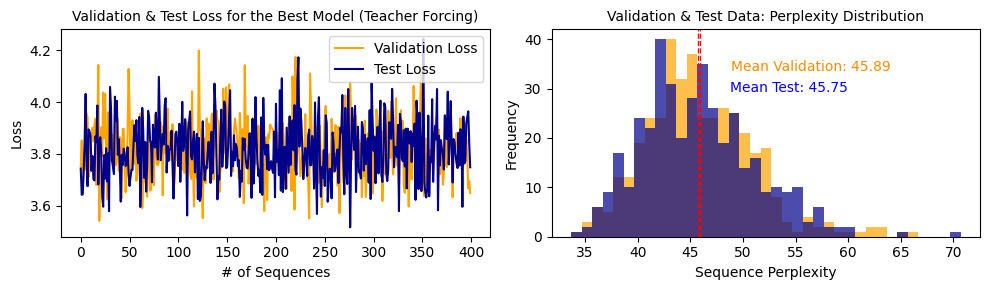

In [166]:
val_perplexity = np.array(val_perplexity)
test_perplexity = np.array(test_perplexity)

mean_test = np.mean(test_perplexity)
mean_val = np.mean(val_perplexity)

bin_start = min(np.min(val_perplexity), np.min(test_perplexity))
bin_stop = max(np.max(val_perplexity), np.max(test_perplexity))
bin_width = 1
bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# Plot 1: Validation & Test Loss
axs[0].plot(val_loss, label='Validation Loss', color='orange')
axs[0].plot(test_loss, label='Test Loss', color='darkblue')
axs[0].legend()
axs[0].set_title('Validation & Test Loss for the Best Model (Teacher Forcing)', size=10)
axs[0].set_xlabel('# of Sequences')
axs[0].set_ylabel('Loss')


# Plot 2: Histogram of Perplexity Distribution
axs[1].hist(val_perplexity, color='orange', bins=bin_edges, alpha=0.7, label='Validation Perplexity')
axs[1].hist(test_perplexity, color='darkblue', bins=bin_edges, alpha=0.7, label='Test Perplexity')
axs[1].set_title('Validation & Test Data: Perplexity Distribution', size=10)
axs[1].set_xlabel('Sequence Perplexity')
axs[1].set_ylabel('Frequency')
#axs[1].set_xlim(1,15)

#Vertical lines for the mean values on the histogram
axs[1].axvline(mean_val, color='red', linewidth=1, linestyle='dashed')
axs[1].axvline(mean_test, color='red', linewidth=1, linestyle='dashed')
axs[1].text(mean_val+3.0, axs[1].get_ylim()[1] * 0.8, f'Mean Validation: {mean_val:.2f}', color='darkorange')
axs[1].text(mean_test+3.0, axs[1].get_ylim()[1] * 0.7, f'Mean Test: {mean_test:.2f}', color='blue')

plt.tight_layout()
plt.show()


#### Inference on Test Data

In [167]:
test_losses = []
trajectories = []

evaluation_model.eval()
with torch.no_grad():

    for sequence in test_data:
    
        token_loss = 0

        # First real Token as start
        init_real_token = sequence[0]
        sim_trajectory = [init_real_token]

        # Initialize hidden and cell states to zero
        ## PLEASE ADJUST WHEN HAVING MULTIPLE LSTM LAYERS
        hidden = (torch.zeros(2, 1, hidden_dim), torch.zeros(2, 1, hidden_dim))
        ##

        for i in range(1, len(sequence)):
            
            # Last value in Trajectory
            sequence_input = torch.tensor([sim_trajectory[-1]]).unsqueeze(0)

            # Model prediction and hidden/cell states
            logits, hidden = evaluation_model(sequence_input, hidden)

            # Softmax
            probs = torch.softmax(logits, dim=-1)
            probs = probs.squeeze()
            # Sample next Token
            predicted_token = torch.multinomial(probs, num_samples=1).item()
            # Add to trajectory
            sim_trajectory.append(predicted_token)

            # Loss
            true_token = torch.tensor([sequence[i]]).unsqueeze(0)
            true_token = true_token.view(-1)
            logits = logits.view(-1, logits.size(-1))
            loss = criterion(logits, true_token)
            token_loss += loss.item()
        
        test_losses.append(token_loss/len(sequence))
        trajectories.append(sim_trajectory)

In [168]:
pure_fake = [trajectories[i][1:] for i in range(len(trajectories))]
flatten_fake = [token for seq in pure_fake for token in seq]

real_entropy = round(calculate_entropy(test_data_temp), 4)
fake_entropy = round(calculate_entropy(flatten_fake), 4)

real_seq_entropy = []
fake_seq_entropy = []

for i in range(len(test_data)):
    real_seq_entropy.append(calculate_entropy(test_data[i]))
    fake_seq_entropy.append(calculate_entropy(pure_fake[i]))

mean_real = np.mean(real_seq_entropy)
mean_fake = np.mean(fake_seq_entropy)

bin_start = min(np.min(real_seq_entropy), np.min(fake_seq_entropy))
bin_stop = max(np.max(real_seq_entropy), np.max(fake_seq_entropy))
bin_width = 0.05
bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)


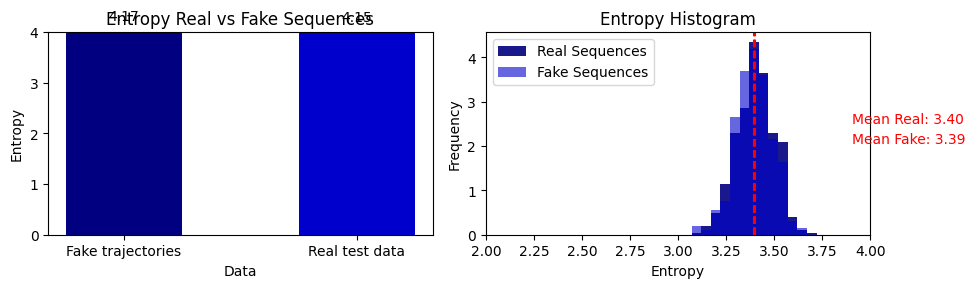

In [169]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

# Plot Barplot
bars = axs[0].bar(x = ['Fake trajectories', 'Real test data'], height=[fake_entropy, real_entropy], width=0.5, color=['navy', 'mediumblue'])
for bar in bars:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')
axs[0].set_title('Entropy Real vs Fake Sequences')
axs[0].set_xlabel('Data')
axs[0].set_ylabel('Entropy')
axs[0].set_ylim(0, 4)

# Plot histograms
axs[1].hist(real_seq_entropy, bins=bin_edges, color='navy', alpha=0.9, label='Real Sequences', density=True)
axs[1].hist(fake_seq_entropy, bins=bin_edges, color='mediumblue', alpha=0.6, label='Fake Sequences', density=True)

# Plot vertical lines for means
axs[1].axvline(mean_real, color='red', linewidth=1.5, linestyle='dashed')
axs[1].axvline(mean_fake, color='red', linewidth=1.5, linestyle='dashed')
y_limit = axs[1].get_ylim()[1]
axs[1].text(mean_real + 0.502, y_limit * 0.55, f'Mean Real: {mean_real:.2f}', color='red')
axs[1].text(mean_fake + 0.51, y_limit * 0.45, f'Mean Fake: {mean_fake:.2f}', color='red')

# Set titles and labels
axs[1].set_title('Entropy Histogram')
axs[1].set_xlabel('Entropy')
axs[1].set_ylabel('Frequency')
axs[1].set_xlim(2,4)
axs[1].legend()

plt.tight_layout()
plt.show()

#print(f"\033[0mREAL DATA Token level entropy:\033[1m {real_entropy}")
#print(f"\033[0mFAKE DATA Token level entropy:\033[1m {fake_entropy}")


In [170]:
def kl_divergence(real_sequence, fake_sequence):

    # Frequency of each token in the real and fake sequences
    real_counts = Counter(real_sequence)
    fake_counts = Counter(fake_sequence)
    
    # Total number of tokens in each sequence
    total_real_tokens = len(real_sequence)
    total_fake_tokens = len(fake_sequence)
    
    # Probability distribution of tokens
    real_probabilities = {token: count / total_real_tokens for token, count in real_counts.items()}
    fake_probabilities = {token: count / total_fake_tokens for token, count in fake_counts.items()}
    
    # KL divergence
    kl_divergence = 0
    for token, p_real in real_probabilities.items():
        p_fake = fake_probabilities.get(token, 1e-10)  # Small value to avoid division by zero
        kl_divergence += p_real * np.log2(p_real / p_fake)
    
    return kl_divergence

def kl_jl(p_real, p_fake):

    kl_divergence = 0
    for token, p_r in p_real.items():
        p_f = p_fake.get(token, 1e-10)  # Add a small value to avoid division by zero
        kl_divergence += p_r * np.log2(p_r / p_f)
    return kl_divergence

def calculate_js_divergence(real_sequence, fake_sequence):

    # Frequency of each token in the real and fake sequences
    real_counts = Counter(real_sequence)
    fake_counts = Counter(fake_sequence)
    
    # Total number of tokens in each sequence
    total_real_tokens = len(real_sequence)
    total_fake_tokens = len(fake_sequence)
    
    # Probability distribution of tokens
    real_probabilities = {token: count / total_real_tokens for token, count in real_counts.items()}
    fake_probabilities = {token: count / total_fake_tokens for token, count in fake_counts.items()}
    
    # Average distribution M
    all_tokens = set(real_probabilities.keys()).union(set(fake_probabilities.keys()))
    average_probabilities = {token: 0.5 * (real_probabilities.get(token, 0) + fake_probabilities.get(token, 0)) for token in all_tokens}
    
    # KL divergence between real and average, and fake and average
    kl_real_to_avg = kl_jl(real_probabilities, average_probabilities)
    kl_fake_to_avg = kl_jl(fake_probabilities, average_probabilities)
    
    # Calculate JS divergence
    js_divergence = 0.5 * (kl_real_to_avg + kl_fake_to_avg)
    
    return js_divergence

In [171]:
kl_div = round(kl_divergence(train_data_temp, flatten_fake),4)
js_div = round(calculate_js_divergence(test_data_temp, flatten_fake),4)

print("KL Divergence between Real and Fake Sequences (in bits):", kl_div)
print('')
print("JS Divergence between Real and Fake Sequences (in bits):", js_div)


KL Divergence between Real and Fake Sequences (in bits): 0.0062

JS Divergence between Real and Fake Sequences (in bits): 0.0026


#### Summary Statistics

In [172]:
def calculate_statistics(trajectories):
    means = []
    variances = []
    std_devs = []
    skewness = []
    kurtos = []
    max_vals = []
    min_vals = []

    for traj in trajectories:
        means.append(np.mean(traj))
        variances.append(np.var(traj))
        std_devs.append(np.std(traj))
        skewness.append(skew(traj))
        kurtos.append(kurtosis(traj))
        max_vals.append(np.max(traj))
        min_vals.append(np.min(traj))
    
    return means, variances, std_devs, skewness, kurtos, max_vals, min_vals

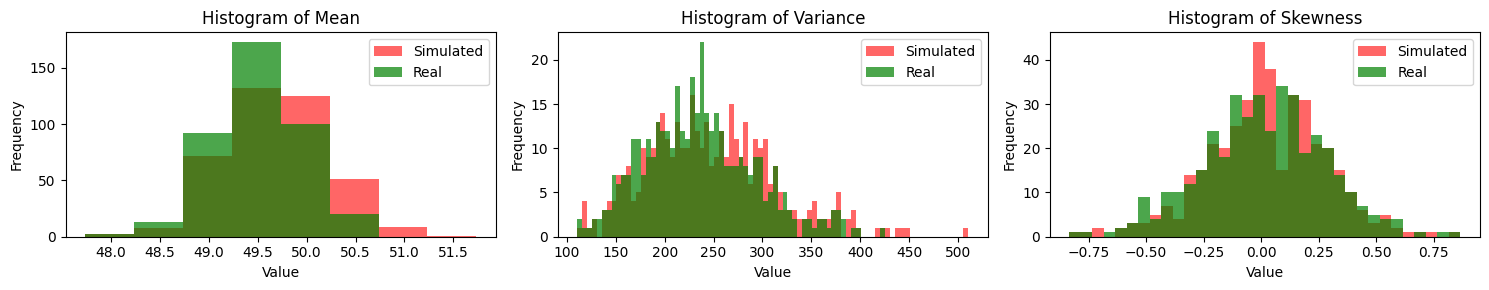

In [173]:
# Statistics for real and simulated trajectories
real_means, real_variances, real_std_devs, real_skew, real_kurtosis, real_max_vals, real_min_vals = calculate_statistics(test_data)
sim_means, sim_variances, sim_std_devs, sim_skew, sim_kurtosis, sim_max_vals, sim_min_vals = calculate_statistics(pure_fake)

bin_start_mean = min(np.min(sim_means), np.min(real_means))
bin_stop_mean = max(np.max(sim_means), np.max(real_means))
bin_width_mean = 0.5
bin_edges_mean = np.arange(bin_start_mean, bin_stop_mean + bin_width_mean, bin_width_mean)

bin_start_var = min(np.min(sim_variances), np.min(real_variances))
bin_stop_var = max(np.max(sim_variances), np.max(real_variances))
bin_width_var = 5
bin_edges_var = np.arange(bin_start_var, bin_stop_var + bin_width_var, bin_width_var)

bin_start_skew = min(np.min(sim_skew), np.min(real_skew))
bin_stop_skew = max(np.max(sim_skew), np.max(real_skew))
bin_width_skew = 0.05
bin_edges_skew = np.arange(bin_start_skew, bin_stop_skew + bin_width_skew, bin_width_skew)

fig, axs = plt.subplots(1, 3, figsize=(15, 3))

# Plot 1: Mean Distribution
axs[0].hist(sim_means, bins=bin_edges_mean, alpha=0.6, label='Simulated', color='red')
axs[0].hist(real_means, bins=bin_edges_mean, alpha=0.7, label='Real', color='green')
axs[0].legend(loc='upper right')
axs[0].set_title('Histogram of Mean')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')

# Plot 1: Variance Distribution
axs[1].hist(sim_variances, bins=bin_edges_var, alpha=0.6, label='Simulated', color='red')
axs[1].hist(real_variances, bins=bin_edges_var, alpha=0.7, label='Real', color='green')
axs[1].legend(loc='upper right')
axs[1].set_title('Histogram of Variance')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')

# Plot 2: Skewness Distribution
axs[2].hist(sim_skew, bins=bin_edges_skew, alpha=0.6, label='Simulated', color='red')
axs[2].hist(real_skew, bins=bin_edges_skew, alpha=0.7, label='Real', color='green')
axs[2].legend(loc='upper right')
axs[2].set_title('Histogram of Skewness')
axs[2].set_xlabel('Value')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

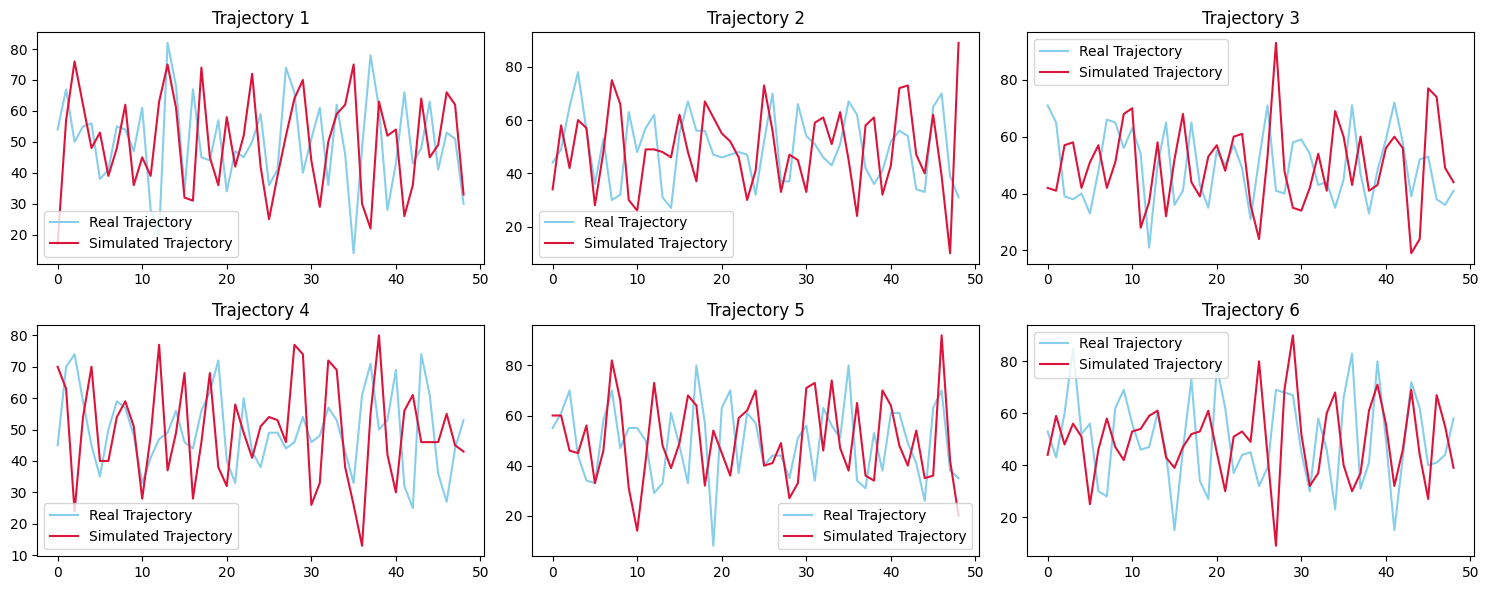

In [174]:
fig, axes = plt.subplots(2, 3, figsize=(15, 6))  # 2 rows, 3 columns, and adjust the size
axes = axes.flatten()
for i in range(6):
    axes[i].plot(test_data[i][1:], label='Real Trajectory', color = 'skyblue')
    axes[i].plot(pure_fake[i], label='Simulated Trajectory', color = 'crimson')
    axes[i].legend()
    axes[i].set_title(f'Trajectory {i+1}')
plt.tight_layout()
plt.show()

In [175]:
test_losses_2 = []
trajectories_2 = []

evaluation_model.eval()
with torch.no_grad():

    for sequence in test_data:
    
        token_loss = 0

        # First real Token as start
        init_real_token = sequence[0]
        sim_trajectory = [init_real_token]

        # Initialize hidden and cell states to zero
        ## PLEASE ADJUST WHEN HAVING MULTIPLE LSTM LAYERS
        h_n = torch.zeros(2, 1, hidden_dim)
        c_n = torch.zeros(2, 1, hidden_dim)
        ##

        for i in range(1, len(sequence)):
            
            # Last value in Trajectory
            sequence_input = torch.tensor([sim_trajectory[-1]]).unsqueeze(0)

            # Model prediction and hidden/cell states
            logits, (h_n, c_n) = evaluation_model(sequence_input, (h_n, c_n))

            # Softmax
            probs = torch.softmax(logits, dim=-1)
            probs = probs.squeeze()
            # Sample next Token
            predicted_token = torch.argmax(probs).item()
            # Add to trajectory
            sim_trajectory.append(predicted_token)

            # Loss
            true_token = torch.tensor([sequence[i]]).unsqueeze(0)
            true_token = true_token.view(-1)
            logits = logits.view(-1, logits.size(-1))
            loss = criterion(logits, true_token)
            token_loss += loss.item()
        
        test_losses_2.append(token_loss/len(sequence))
        trajectories_2.append(sim_trajectory)

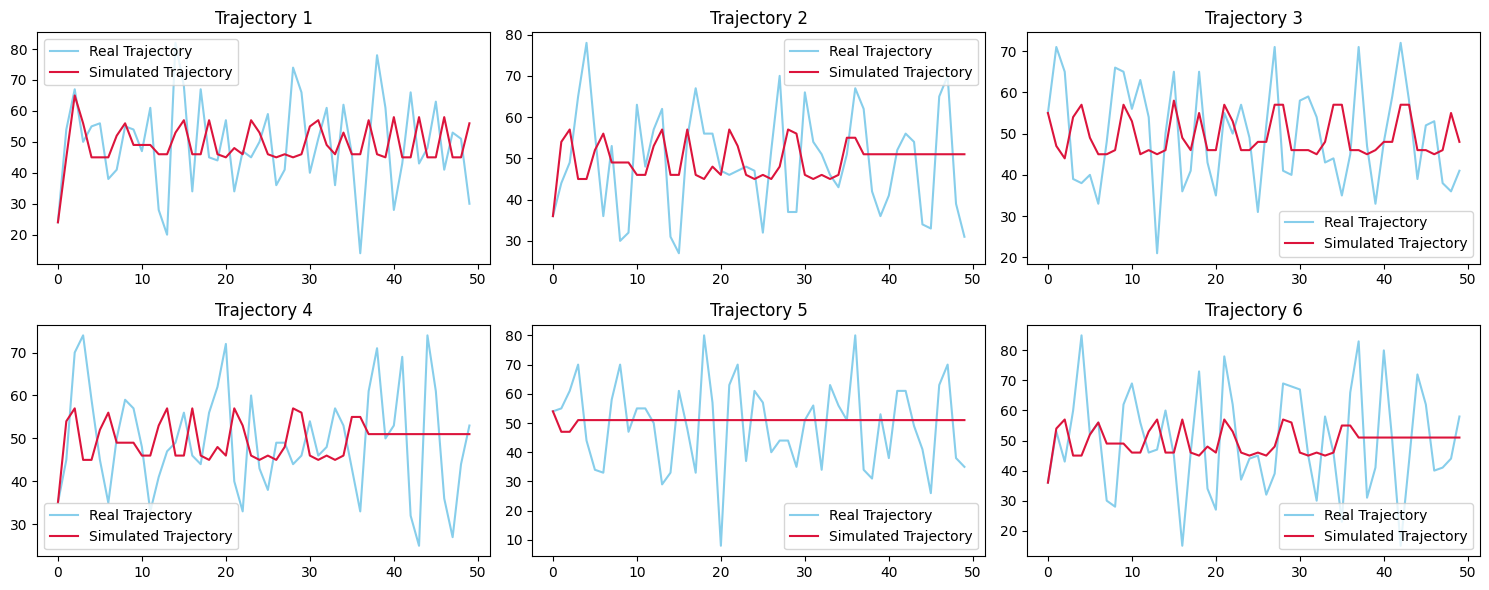

In [176]:
fig, axes = plt.subplots(2, 3, figsize=(15, 6))  # 2 rows, 3 columns, and adjust the size
axes = axes.flatten()
for i in range(6):
    axes[i].plot(test_data[i], label='Real Trajectory', color = 'skyblue')
    axes[i].plot(trajectories_2[i], label='Simulated Trajectory', color = 'crimson')
    axes[i].legend()
    axes[i].set_title(f'Trajectory {i+1}')
plt.tight_layout()
plt.show()

In [148]:
# Function to calculate ACF for each trajectory
def calculate_acf(trajectories, nlags=10):
    acfs = []
    for traj in trajectories:
        acf_values = acf(traj, fft=False, nlags=nlags)
        acfs.append(acf_values)
    return np.array(acfs)

# Function to calculate PACF for each trajectory
def calculate_pacf(trajectories, nlags=10):
    pacfs = []
    for traj in trajectories:
        pacf_values = pacf(traj, nlags=nlags)
        pacfs.append(pacf_values)
    return np.array(pacfs)

# ACFs for real and simulated trajectories
real_acfs = calculate_acf([test_data[i][1:] for i in range(len(test_data))])
simulated_acfs = calculate_acf(pure_fake)
# Average the ACFs across all trajectories
avg_real_acf = np.mean(real_acfs, axis=0)
avg_simulated_acf = np.mean(simulated_acfs, axis=0)

# Calculate PACFs for real and simulated trajectories
real_pacfs = calculate_pacf([test_data[i][1:] for i in range(len(test_data))])
simulated_pacfs = calculate_pacf(pure_fake)
# Average the PACFs across all trajectories
avg_real_pacf = np.mean(real_pacfs, axis=0)
avg_simulated_pacf = np.mean(simulated_pacfs, axis=0)

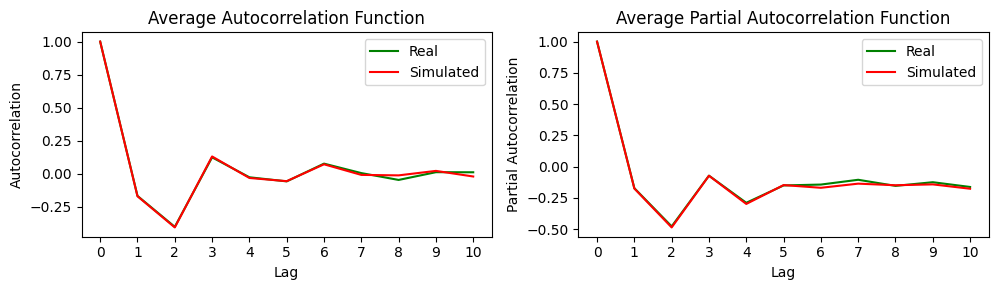

In [74]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# Plot the averaged ACFs
axs[0].plot(avg_real_acf, label='Real', color='green')
axs[0].plot(avg_simulated_acf, label='Simulated', color='red')
axs[0].set_title('Average Autocorrelation Function')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('Autocorrelation')
axs[0].set_xticks(np.arange(0, 11, 1))
axs[0].legend()

# Plot the averaged PACFs
axs[1].plot(avg_real_pacf, label='Real', color='green')
axs[1].plot(avg_simulated_pacf, label='Simulated', color='red')
axs[1].set_title('Average Partial Autocorrelation Function')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('Partial Autocorrelation')
axs[1].set_xticks(np.arange(0, 11, 1))
axs[1].legend()

plt.tight_layout()
plt.show()
